In [1]:
%cd ../..

/volatile/home/Zaccharie/workspace/understanding-unets


In [2]:
# # this just to make sure we are using only on CPU
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [3]:
%matplotlib nbagg
import os.path as op
import time

from fastmri_recon.config import *
from fastmri_recon.data.fastmri_tf_datasets import train_masked_kspace_dataset_from_indexable
from fastmri_recon.helpers.nn_mri import tf_fastmri_format
from fastmri_recon.helpers.utils import keras_psnr, keras_ssim
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tqdm.notebook import tqdm

from learning_wavelets.keras_utils.fourier import tf_masked_shifted_normed_fft2d, tf_masked_shifted_normed_ifft2d
from learning_wavelets.models.ista import IstaLearnlet

In [4]:
# paths
train_path = f'{FASTMRI_DATA_DIR}singlecoil_train/singlecoil_train/'
val_path = f'{FASTMRI_DATA_DIR}singlecoil_val/'
test_path = f'{FASTMRI_DATA_DIR}singlecoil_test/'

n_volumes_train = 973
af = 4
contrast = 'CORPDFS_FBK'
train_set = train_masked_kspace_dataset_from_indexable(
    train_path,
    AF=af,
    inner_slices=1,
    rand=False,
    scale_factor=1e6,
    contrast=contrast,  # CORPDFS_FBK CORPD_FBK None
    shuffle=False,
)
val_set = train_masked_kspace_dataset_from_indexable(
    val_path,
    AF=af,
    contrast=contrast,
    scale_factor=1,
)

Getting training files from /media/Zaccharie/UHRes/singlecoil_train/singlecoil_train/
Getting training files from /media/Zaccharie/UHRes/singlecoil_val/


In [5]:
learnlet_params = {
    'denoising_activation': 'dynamic_soft_thresholding',
    'learnlet_analysis_kwargs':{
        'coarse': True,
    },
    'learnlet_synthesis_kwargs': {
        'res': True,
    },
    'threshold_kwargs':{
        'noise_std_norm': False,
        'alpha_init': 0,
    },
    'n_scales': 3,
    'exact_reconstruction': False,
    'wav_only': True,
    'undecimated': False,
    'clip': False,
}

model = IstaLearnlet(
    n_iterations=200,
    forward_operator=tf_masked_shifted_normed_fft2d,
    adjoint_operator=tf_masked_shifted_normed_ifft2d,
    postprocess=tf_fastmri_format,
    fista_mode=True,
    **learnlet_params,
)
model.compile(
    optimizer=Adam(lr=1e-3),
    loss='mse',
    metrics=[keras_psnr, keras_ssim,],
)
model([tf.zeros((1, 640, 320, 1), dtype=tf.complex64), tf.zeros((1, 640, 320), dtype=tf.complex64)]);

In [6]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [13]:
mus_to_test = np.logspace(-5, -3.5, 7)
mus_metrics = {}
n_samples = 10
for mu in tqdm(mus_to_test):
    [l.set_weights([np.array([mu])]) for l in model.learnlet.threshold.thresholding_layers]
    psnr_gain_array = tf.TensorArray(tf.float32, n_samples)
    i = 0
    for (kspace, mask), image in tqdm(train_set.take(n_samples), total=n_samples):
        res = model([kspace, mask])
        model_psnr = keras_psnr(image, res)
        z_filled = tf_fastmri_format(tf_masked_shifted_normed_ifft2d(kspace[..., 0], mask)[..., None])
        z_psnr = keras_psnr(image, z_filled)
        psnr_gain_array = psnr_gain_array.write(i, model_psnr - z_psnr)
        i += 1
    mus_metrics[mu] = tf.reduce_mean(psnr_gain_array.stack()).numpy()

<IPython.core.display.Javascript object>


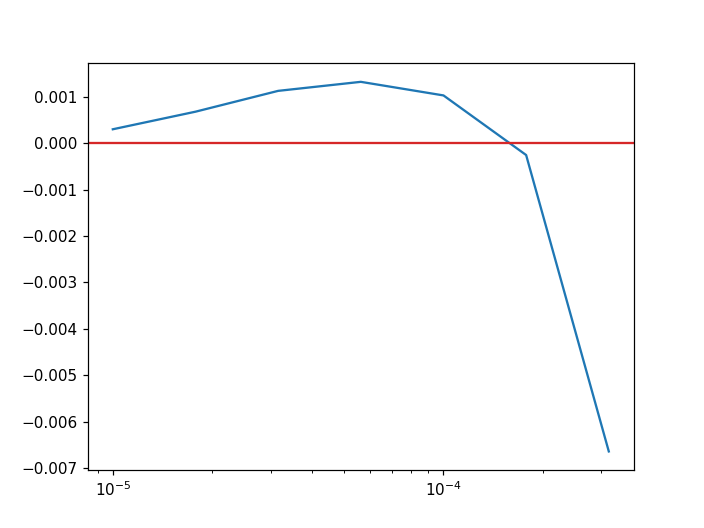

In [14]:
plt.figure()
plt.plot([k for k in mus_metrics.keys()], [v for v in mus_metrics.values()])
plt.xscale('log')
plt.axhline(0, color='C3')